In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time as tm

# Parameters

In [6]:
# Defining parameters - parameters taken from  Richter&Gjorgjieva, 2021


def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['C_m'] = 200.      # membrane capacitance [pF]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['E_L'] = -70.      # leak reversal potential [mV] # change from EL
  pars['V_th'] = -50.     # Threshold potential [mV] # Vth?
  pars['V_reset'] = -58.  # Post-spike reset potential [mV] # Vre?
  pars['VE'] = 0.         # Excitatory reversal potential [mV]
  pars['VI'] = -85.       # Inhibitory reversal potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms] # change from taum
  pars['N_E'] = 90.       # nr of excitatory neurons
  pars['N_I'] = 10.       # nr of inhibitory neurons
  pars['V_init'] = -75.   # initial potential [mV]
  pars['p'] = 0.1         # connection probability between two cells
  pars['tref'] = 2.       # refractory time (ms) # I guess DT
  pars['gE_bar'] = 2.4    # [nS]
  pars['gI_bar'] = 2.4    # [nS]
  pars['tau_syn'] = 5.    # synaptic conductance time constant [ms] 
  pars['tau_syn_E'] = 5.  # excitatory synaptic conductance time constant [ms]
  pars['tau_syn_I'] = 5.  # inhibitory synaptic conductance time constant [ms]
  pars['Vth'] = 0.        # Threshold potential [mV] from other code????
  pars['Vre'] = -73.      # Post-spike reset potential [mV] from other code????
  pars['DT'] = 2.         # refractory time (ms) from other code????
  pars['VT'] = -55.       # no idea what kind of potential 
  pars['Vlb'] = -80.      # no idea what kind of potential. some kind of lower boundary?


  # simulation parameters #
  pars['T'] = 1000.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()
# print(pars)

# Build Poisson spike trains and make a raster plot

`sx` is a family of $N_x$ Poisson processes modeling the spike times of $N_x$ neurons. It is stored as a matrix with two rows. The first row, `s[0,:]`, is a vector of spike times (random numbers in $[0,T]$) and `sx[1,:]` is a vector of associated neuron indices (integers from  $0$ to  $N_x-1$). 

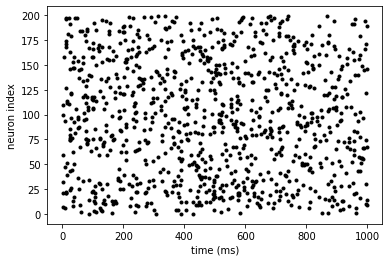

In [7]:
# buiding poisson spike trains

def Poisson_generator(pars, rx, Nx, myseed=False):
  """
  Generates poisson trains and produces raster plot

  Args:
    pars       : parameter dictionary
    rx         : noise amplitute [Hz]
    Nx         : number of neurons
    myseed     : random seed. int or boolean

  Returns:
    sx         : matrix with two rows - s[0,:] being a spike times vector
                and sx[1,:] is a vector of associated neuron indices
  """

  # Retrieve simulation parameters
  T = pars['T']

  # set random seed
  if myseed:
      np.random.seed(seed=myseed)
  else:
      np.random.seed()

  # The total number of spikes obeys a Poisson
  # distribution with expectation rx*Nx*T
  numspikesX=np.random.poisson(rx*Nx*T)
  sx=np.zeros((2,numspikesX))

  # Spike times and indices are uniformly distributed
  # once we condition on the total number of spikes
  sx[0,:]=np.random.rand(numspikesX)*T
  sx[1,:]=np.random.randint(0,Nx,size=numspikesX)

  # Sort the spike times 
  temp=np.argsort(sx[0,:])
  sx=sx[:,temp]

  # Raster plot
  plt.figure()
  plt.plot(sx[0,:],sx[1,:],'k.')
  plt.xlabel('time (ms)')
  plt.ylabel('neuron index')

  return sx

# Get parameters
pars = default_pars(T=1000)

# Simulate Poisson train
sx = Poisson_generator(pars, Nx = 200, rx = 5/1000)


# Modeling a postsynaptic current

We now model the current across a postsynaptic neuron's membrane assuming that the neuron receives excitatory synaptic input from all $N_x$ of the neurons modeled by the Poisson processes above. Each presynaptic spike evokes an exponentially decaying current pulse so the current is given by
$$
I_x(t)=\sum_{k=1}^{N_x}j_x\sum_i \alpha_x(t-t_{i,k})
$$
where $t_{i,k}$ is the $i$th spike time of neuron $k=1,\ldots,N_x$,
$$
\alpha_x(t)=e^{-t/\tau_x}H(t),
$$
and $H(t)$ is the Heavisde step function. The current can equivalently be modeled by the ODE
$$
\tau_x\frac{dI_x}{dt}=-I_x
$$
with the added rule
$$
I_x(t_{i,k})\gets I_x(t_{i,k})+j_x/\tau_x
$$

**Theory:** The mean  synaptic current is  given by 
$$
\overline{I}_x=N_x j_x r_x
$$

In [5]:
# Build a discretized time vector
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Define parameters
taux=10
jx=15

# Initialize Ix
Ix=np.zeros_like(time)

# Implement the ODE version of the Ix model
ix=0
for i in range(1,Nt):
  Ix[i]=Ix[i-1]-dt*Ix[i-1]/taux
  while (ix<numspikesX and sx[0,ix]<=i*dt):
    Ix[i]+=jx/taux
    ix+=1

# This is the theoretical stationary mean value
# of Ix, i.e., E[Ix]
Ixbar=Nx*jx*rx

print('Theoretical mean of Ix:',Ixbar)
print('Empirical mean of Ix:',np.mean(Ix))

# Raster plot
plt.figure()
plt.plot(sx[0,:],sx[1,:],'k.')
plt.xlabel('time (ms)')
plt.ylabel('neuron index')

# Plot Ix and compare to predicted mean
plt.figure()
plt.plot(time,Ix,'g')
plt.plot(time,Ixbar+0*time,'g--')
plt.xlabel('time (ms)')
plt.ylabel('synaptic input (mV)')


NameError: ignored

# Modeling a postsynaptic neuron

Now model the membrane potential of a postsynaptic neuron using the exponential integrate-and-fire (EIF) model, which obeys the ODE
$$
\tau_m \frac{dV}{dt}=-(V-E_L)+D_T e^{(V-V_T)/D_T}+I_x
$$
with the added condition
$$
V(t)\ge V_{th}\Rightarrow V(t)\gets V_{re},\textrm{ record a spike}
$$

LIF 
	
\tau_m \frac{du}{dt}=−[u(t)−urest]+RI(t).


In [ ]:
# Modeling a postsynaptic neuron

def EIF_simulation(pars, rx, Nx, myseed=False):
  """
  Simulate the EIF dynamics with Poisson processes

  Args:
    pars       : parameter dictionary
    rx         : noise amplitute [Hz]
    Nx         : number of neurons
    myseed     : random seed. int or boolean

  Returns:
    sx         : matrix with two rows - s[0,:] being a spike times vector
                and sx[1,:] is a vector of associated neuron indices
  """

  # Retrieve parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']
  T= pars['T']

  # Neuron parameters
  taum=15
  EL=-72
  Vth=0
  Vre=-73
  DT=2
  VT=-55
  Vlb=-80

  # Initialize V 
  V=np.zeros_like(time)
  V[0]=E_L

  # Initialize postsynaptic spike train
  # Max number of spikes to store = 100Hz
  maxnumspikes=(int)(T*100/1000)
  s=np.zeros(maxnumspikes)
  nspike=0

  # Euler loop
  for i in range(1,Nt):
    V[i]=V[i-1]+dt*(Ix[i-1]+(E_L-V[i-1])+DT*np.exp((V[i-1]-VT)/DT))/tau_m
    V[i]=np.maximum(V[i],Vlb)

    if (V[i]>=Vth and nspike<maxnumspikes):    
      V[i]=Vre
      V[i-1]=Vth # This just makes plots look nicer
      s[nspike]=i*dt
      nspike+=1

  # Get rid of unused space in s
  print("Nspike:", nspike)
  s=s[:nspike]
  print("S: ", s)

  # Compute rate
  rate=(nspike)/T
  print('Postsynaptic rate =',1000*rate,'Hz')

  # Plot membrane potential
  plt.figure()
  plt.plot(time,V)
  plt.plot(s,np.max(V)+0*s,'ro')
  plt.xlabel('time (ms)')
  plt.ylabel('membrane potential (mV)')





# Modeling a single-layer feedforward network

Now we consider the same Posson presynaptic layer, but with $N$ postsynaptic neurons. Each presynaptic neuron connects to each postsynaptic neuron with probability $p_x$. 

The model obeys
$$
\tau_x\frac{d\vec I_x}{dt}=-\vec I_x
$$
$$
\tau_m \frac{d\vec V}{dt}=-(\vec V-E_L)+D_T e^{(\vec V-V_T)/D_T}+\vec I_x
$$
with the added rules
$$
\vec I_x(t_{i,k})\gets \vec I_x(t_{i,k})+J_x(:,k)
$$
and
$$
V_j(t)\ge V_{th}\Rightarrow V_j(t)\gets V_{re},\textrm{ record a spike in neuron }j
$$

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0 15  0 ... 15  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [15  0  0 ...  0 15 15]
 [15 15  0 ...  0  0  0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in add


Mean postsynaptic rate= 7.276000000000001 Hz
Theoretical mean synaptic input= 15.0 mV
Sample mean synaptic input= 14.786685379550974 mV


Text(0.5, 0, 'time (ms)')

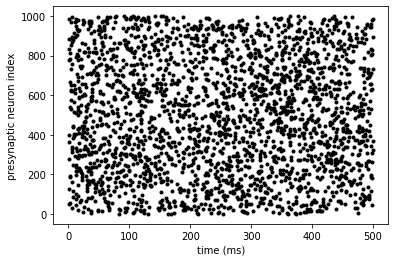

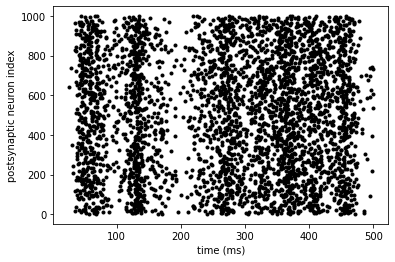

In [ ]:
# First define the duration (in ms)
T=500

# Number and rate of Poisson processes
Nx=1000 #nr of poisson processes
rx=5/1000
N=1000 #nr of neurons

# Connection probability, weight,
# and synaptic timescale
px=.2
taux=10
jx=15

# Connectivity matrix from presynaptic population 
# to postsynaptic population
Jx=jx*np.random.binomial(1,px,(N,Nx))
print(Jx)

# Build a discretized time vector
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Neuron parameters
taum=15
EL=-72
Vth=0
Vre=-73
DT=2
VT=-55
Vlb=-80


# The total number of spikes obeys a Poisson
# distribution with expectation rx*Nx*T
numspikesX=np.random.poisson(rx*Nx*T)
sx=np.zeros((2,numspikesX))

# Spike times and indices are uniformly distributed
# once we condition on the total number of spikes
sx[0,:]=np.random.rand(numspikesX)*T
sx[1,:]=np.random.randint(0,Nx,size=numspikesX)

# Sort the spike times 
temp=np.argsort(sx[0,:])
sx=sx[:,temp]

# Initialize V and Ix. Now we don't store every time point
Ix=np.zeros(N)
V=np.random.rand(N)*(VT-EL)+EL

# Initialize postsynaptic spike train. Now we
# need to use the same data structure as for sx
maxnumspikes=(int)(N*T*100/1000)
s=-1+np.zeros((2,maxnumspikes))
nspike=0
ix=0
for i in range(1,Nt):

  # Update synaptic current
  Ix=Ix-dt*Ix/taux
  while (ix<numspikesX and sx[0,ix]<=i*dt):
    Ix+=Jx[:,(int)(sx[1,ix])]/taux
    ix+=1

  # Update membrane potential
  V=V+dt*(Ix+(EL-V)+DT*np.exp((V-VT)/DT))/taum
  V=np.maximum(V,Vlb)

  # Find which neurons spiked      
  Ispike = np.nonzero(V>=Vth)[0]        
  if Ispike.any():
      # Store spike times and neuron indices
      if (nspike+len(Ispike)<=maxnumspikes):
          s[0,nspike:nspike+len(Ispike)]=dt*i
          s[1,nspike:nspike+len(Ispike)]=Ispike

      # Reset membrane potential
      V[Ispike]=Vre
  
      # Update cumulative number of spikes
      nspike=nspike+len(Ispike)

# Get rid of unused space in s
s=s[:,:nspike]

# Mean rate
MeanRate=nspike/(N*T)
print('Mean postsynaptic rate=',MeanRate*1000,'Hz')

# Mean-field synaptic weight
wx=jx*px*Nx

# Mean-field input
Ixbar=wx*rx
print('Theoretical mean synaptic input=',Ixbar,'mV')
print('Sample mean synaptic input=',np.mean(Ix),'mV')

# Raster plot
plt.figure()
plt.plot(sx[0,:],sx[1,:],'k.')
plt.ylabel('presynaptic neuron index')
plt.xlabel('time (ms)')

plt.figure()
plt.plot(s[0,:],s[1,:],'k.')
plt.ylabel('postsynaptic neuron index')
plt.xlabel('time (ms)')



# Modeling a recurrent network

We now add recurrent connections between the $N$ neurons, $N_e$ of which are excitatory and $N_i$ are inhibitory. This makes three populations altother: An external population of Poisson processes (x), the downstream exciitatory population (e), and the downstream inhibitory population (i). The connection probability from population $b=e,i,x$ to population $a=e,i$ is denoted $p_{ab}$ and the synaptic weight by $j_{ab}$. 

The synaptic current from population $b=e,i,x$ to population $a=e,i$ obeys
$$
\tau_{b}\frac{d\vec I_{ab}}{dt}=-\vec I_{ab}
$$
with the added rule
$$
\vec I_{ab}(t^b_{i,k})\gets \vec I_x(t^b_{i,k})+J_{ab}(:,k)/\tau_b
$$
where $t^b_{i,k}$ is the $i$th spike of neuron $k$ in population $b$ and $J_{ab}$ is the connection matrix from from population $b=e,i,x$ to population $a=e,i$.

The membrane potentials of neurons in population $a=e,i$ obey
$$
\tau_m \frac{d\vec V_a}{dt}=-(\vec V_a-E_L)+D_T e^{(\vec V_a-V_T)/D_T}+\vec I_{ae}+\vec I_{ai}+\vec I_{ax}
$$
with the added rule
$$
V_j(t)\ge V_{th}\Rightarrow V_j(t)\gets V_{re},\textrm{ record a spike in neuron }j
$$

**Theory:**
The mean input from $b$ to $a$ is given by
$$
\overline{I_{ab}}=w_{ab}r_b
$$
where
$$
w_{ab}=N_b p_{ab}j_{ab}
$$
and $r_b$ is the mean rate of neurons in population $b$. If 
$$
j_{ab}\sim 1/\sqrt N
$$ 
where $N_b\sim N$ then 
$$
\overline{I_{ab}}\sim\sqrt N.
$$
Now let 
$$
\overline{I_a}=I_{ae}+I_{ai}+I_{ax}
$$
be the mean-field total input to neurons in population $a$. 
Then we can only have 
$$
r_a,\overline{I_a}\sim\mathcal O(1) 
$$
if there is a cancellation between $I_{ae}$, $I_{ai}$, and $I_{ax}$ in the large $N$ limit. We can write 
$$
{\bf I}=\left[\begin{array}{c}\overline{I_e}\\ \overline{I_i}\end{array}\right]=W{\bf r}+W_x r_x
$$
where 
$$
W=\left[\begin{array}{cc}w_{ee} & w_{ei}\\ w_{ie} & w_{ii}\end{array}\right]
$$
$$
W_x=\left[\begin{array}{c}w_{ex}\\ w_{ix}\end{array}\right]
$$
and
$$
{\bf r}=\left[\begin{array}{c}{r_e}\\ {r_i}\end{array}\right]
$$
Cancellation requires that 
$$
W{\bf r}\approx -W_x r_x
$$
in the large $N$ limit, so 
$$
\lim_{N\to\infty}{\bf r}=-W^{-1}W_x r_x
$$


Time for simulation= 24.39058208465576 sec
Mean exc rate= 8.725999999999999 Hz
Mean inh rate= 18.8305 Hz
Theoretical exc rate approx= 8.823529411764707 Hz
Theoretical inh rate approx= 20.16806722689076 Hz


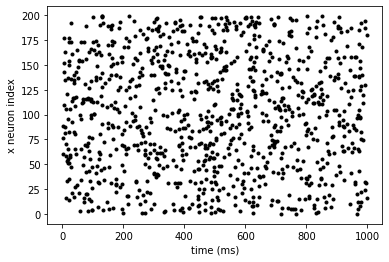

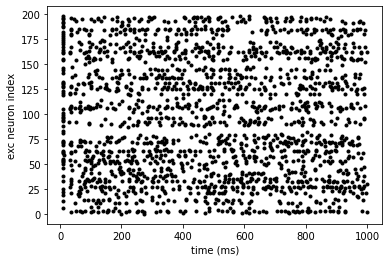

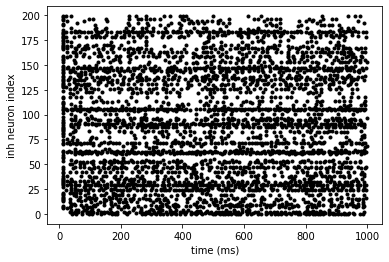

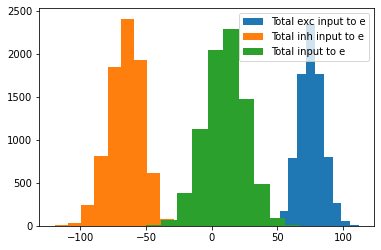

Mean exc, inh, total inputs to e: 75.60329958676789 -65.33695561967798 10.266343967089906


In [ ]:
# First define the duration (in ms)
T=1000

# Number and rate of Poisson processes
Nx=4000
rx=5/1000
Ne=8000
Ni=2000
N=Ne+Ni

# Connection probabilities
pee=0.1
pei=0.1
pie=0.1
pii=0.1
pex=0.1
pix=0.1

# Synaptic weights
jee=350/np.sqrt(N)
jei=-2100/np.sqrt(N)
jie=1575/np.sqrt(N)
jii=-3500/np.sqrt(N)
jex=3000/np.sqrt(N)
jix=1500/np.sqrt(N)

# Synaptic timescales
taux=10
taue=8
taui=4

# Connectivity matrix from presynaptic population 
# to postsynaptic population
Jee=jee*np.random.binomial(1,pee,(Ne,Ne))
Jei=jei*np.random.binomial(1,pei,(Ne,Ni))
Jie=jie*np.random.binomial(1,pie,(Ni,Ne))
Jii=jii*np.random.binomial(1,pii,(Ni,Ni))
Jex=jex*np.random.binomial(1,pex,(Ne,Nx))
Jix=jix*np.random.binomial(1,pix,(Ni,Nx))

# Build a discretized time vector
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Neuron parameters
taum=15
EL=-72
Vth=0
Vre=-73
DT=2
VT=-55
Vlb=-80

# The total number of spikes obeys a Poisson
# distribution with expectation rx*Nx*T
numspikesX=np.random.poisson(rx*Nx*T)
sx=np.zeros((2,numspikesX))

# Spike times and indices are uniformly distributed
# once we condition on the total number of spikes
sx[0,:]=np.random.rand(numspikesX)*T
sx[1,:]=np.random.randint(0,Nx,size=numspikesX)

# Sort the spike times 
temp=np.argsort(sx[0,:])
sx=sx[:,temp]

# Initialize V and Ix. Now we don't store every time point
Iee=np.zeros(Ne)
Iei=np.zeros(Ne)
Iie=np.zeros(Ni)
Iii=np.zeros(Ni)
Iex=np.zeros(Ne)
Iix=np.zeros(Ni)
Ve=np.random.rand(Ne)*(VT-EL)+EL
Vi=np.random.rand(Ni)*(VT-EL)+EL

# Initialize postsynaptic spike train. Now we
# need to use the same data structure as for sx
maxnumespikes=(int)(Ne*T*100/1000)
se=-1+np.zeros((2,maxnumespikes))
maxnumispikes=(int)(Ni*T*100/1000)
si=-1+np.zeros((2,maxnumispikes))
nespike=0
nispike=0
ix=0
startsim = tm()
for i in range(1,Nt):

  # Update synaptic current
  Iee=Iee-dt*Iee/taue
  Iei=Iei-dt*Iei/taui
  Iie=Iie-dt*Iie/taue
  Iii=Iii-dt*Iii/taui
  Iex=Iex-dt*Iex/taux
  Iix=Iix-dt*Iix/taux

  while (ix<numspikesX and sx[0,ix]<=i*dt):
    Iex+=Jex[:,(int)(sx[1,ix])]/taux
    Iix+=Jix[:,(int)(sx[1,ix])]/taux
    ix+=1

  # Update membrane potential
  Ve=Ve+dt*(Iee+Iei+Iex+(EL-Ve)+DT*np.exp((Ve-VT)/DT))/taum
  Ve=np.maximum(Ve,Vlb)
  Vi=Vi+dt*(Iie+Iii+Iix+(EL-Vi)+DT*np.exp((Vi-VT)/DT))/taum
  Vi=np.maximum(Vi,Vlb)

  # Find which e neurons spiked      
  Iespike = np.nonzero(Ve>=Vth)[0]        
  if Iespike.any():
      # Store spike times and neuron indices
      if (nespike+len(Iespike)<=maxnumespikes):
          se[0,nespike:nespike+len(Iespike)]=dt*i
          se[1,nespike:nespike+len(Iespike)]=Iespike

      # Reset membrane potential
      Ve[Iespike]=Vre

      # Propagate spikes
      Iee=Iee+Jee[:,Iespike].sum(axis = 1)/taue
      Iie=Iie+Jie[:,Iespike].sum(axis = 1)/taue
  
      # Update cumulative number of spikes
      nespike=nespike+len(Iespike)

  # Find which i neurons spiked      
  Iispike = np.nonzero(Vi>=Vth)[0]        
  if Iispike.any():
      # Store spike times and neuron indices
      if (nispike+len(Iispike)<=maxnumispikes):
          si[0,nispike:nispike+len(Iispike)]=dt*i
          si[1,nispike:nispike+len(Iispike)]=Iispike

      # Reset membrane potential
      Vi[Iispike]=Vre

      # Propagate spikes
      Iei=Iei+Jei[:,Iispike].sum(axis = 1)/taui
      Iii=Iii+Jii[:,Iispike].sum(axis = 1)/taui
      
  
      # Update cumulative number of spikes
      nispike=nispike+len(Iispike)


# Get rid of unused space in s
se=se[:,:nespike]
si=si[:,:nispike]
simtime = tm()-startsim
print('Time for simulation=',simtime,'sec')

# Mean rates
MeaneRate=nespike/(Ne*T)
MeaniRate=nispike/(Ni*T)
print('Mean exc rate=',MeaneRate*1000,'Hz')
print('Mean inh rate=',MeaniRate*1000,'Hz')

# Raster plots
numplot=200 # Number of neurons to plot

plt.figure()
plt.plot(sx[0,sx[1,:]<numplot],sx[1,sx[1,:]<numplot],'k.')
plt.ylabel('x neuron index')
plt.xlabel('time (ms)')

plt.figure()
plt.plot(se[0,se[1,:]<numplot],se[1,se[1,:]<numplot],'k.')
plt.ylabel('exc neuron index')
plt.xlabel('time (ms)')

plt.figure()
plt.plot(si[0,si[1,:]<numplot],si[1,si[1,:]<numplot],'k.')
plt.ylabel('inh neuron index')
plt.xlabel('time (ms)')


# Mean-field weights
wee=Ne*pee*jee
wei=Ni*pei*jei
wie=Ne*pie*jie
wii=Ni*pii*jii
wex=Nx*pex*jex
wix=Nx*pix*jix

# Mean rates predicted by balanced network approx
W=np.array([[wee,wei],[wie,wii]])
Wx=np.array([[wex],[wix]])
rBal=-np.linalg.inv(W)@Wx*rx

print('Theoretical exc rate approx=',rBal[0][0]*1000,'Hz')
print('Theoretical inh rate approx=',rBal[1][0]*1000,'Hz')


# Plot histograms of input currents to viisualize balance
plt.figure()
plt.hist(Iee+Iex)
plt.hist(Iei)
plt.hist(Iee+Iex+Iei)
plt.gca().legend(('Total exc input to e','Total inh input to e','Total input to e'))
plt.show()

print('Mean exc, inh, total inputs to e:',(Iee+Iex).mean(),(Iei).mean(),(Iee+Iex+Iei).mean())
